In [1]:
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from dataloader import FastTensorDataLoader

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Generation

In [3]:
def generate_poisson_points(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    area = (xmax - xmin) * (ymax - ymin)
    max_intensity = kappa * area  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()


def generate_poisson_points_1d(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 1D region based on an intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as (xmin, xmax).
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP in 1D.
    """
    xmin, xmax = region

    # Length of the region
    length = xmax - xmin
    max_intensity = kappa * length  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)  # Number of candidate samples

    # Generate candidate points
    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    candidates = torch.tensor(x_candidates, dtype=torch.float32)
    
    # Calculate intensity
    squared_norm = candidates**2
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    # Perform rejection sampling
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()

## Data 1d

In [4]:
kappa = torch.tensor(1000.0)
scale = torch.tensor(0.6)

region = (0, 3)

In [5]:
num_samples = 100
samples = []
for _ in range(num_samples):
    x_t = generate_poisson_points_1d(kappa, scale, region)
    samples.append(torch.tensor(x_t).unsqueeze(-1))

## Data 2d

In [22]:
kappa = torch.tensor(1000.0)
scale = torch.tensor(0.5)

region = ((0, 1), (0, 1))

In [23]:
num_samples = 100
samples = []
for _ in range(num_samples):
    x_t = generate_poisson_points(kappa, scale, region)
    samples.append(torch.tensor(x_t))

## Data Loader

In [24]:
train_ratio = 0.8
batch_size = 32
samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]

X = pad_sequence(samples_torch, batch_first=True, padding_value=0)

lengths = torch.tensor([len(s) for s in samples_torch], dtype=torch.int64)
lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

m = len(X)
train_size = int(train_ratio * m)

X_train = X[:train_size]
X_test = X[train_size:]

loader_train = FastTensorDataLoader(X_train, batch_size=batch_size, shuffle=True)
loader_test = FastTensorDataLoader(X_test, batch_size=batch_size, shuffle=False)

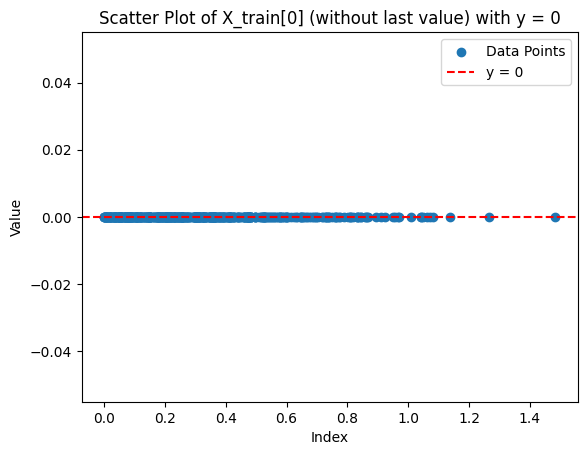

In [7]:
length = int(X_train[0][0][-1].item())
x_plot = X_train[0][:length][:, 0]

plt.scatter(x_plot, np.zeros_like(x_plot), label='Data Points')
plt.axhline(0, color='red', linestyle='--', label='y = 0')
plt.title('Scatter Plot of X_train[0] (without last value) with y = 0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

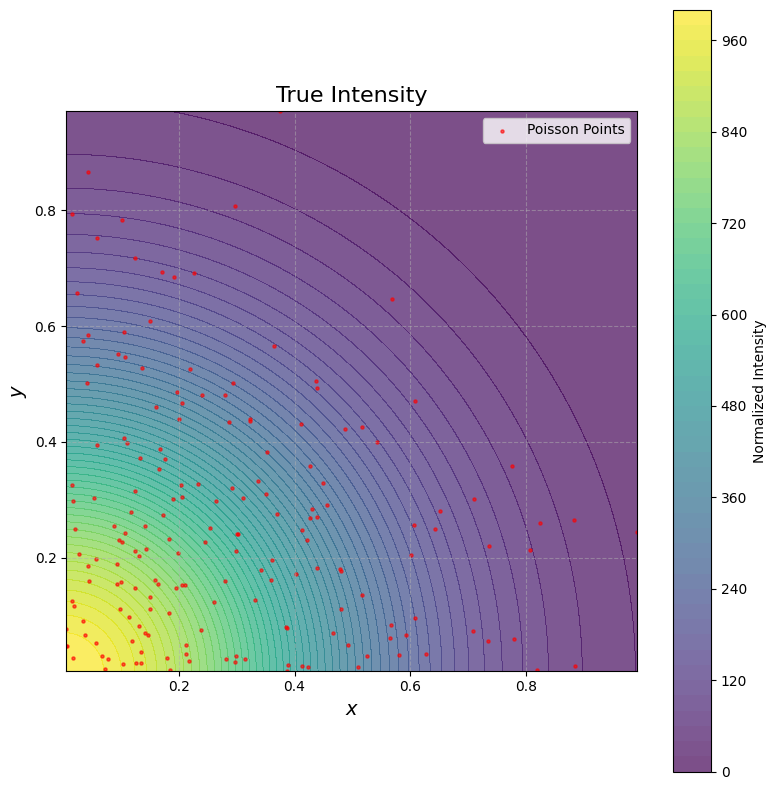

In [25]:
length = int(X_train[0][0][-1].item())
x_plot = X_train[0][:length][:,:-1]

x = x_plot[:, 0].numpy()
y = x_plot[:, 1].numpy()
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

x_lin = np.linspace(x_min, x_max, 100)
y_lin = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_lin, y_lin)

grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
    
intensity_real = kappa.item() * np.exp(-(xx**2 + yy**2) / scale**2)

fig, ax = plt.subplots(figsize=(8, 8))

if isinstance(intensity_real, torch.Tensor):
    intensity_real = intensity_real.numpy()
c = ax.contourf(
    xx, yy, intensity_real, levels=50,
    cmap='viridis', alpha=0.7,
)
ax.scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
ax.set_title('True Intensity', fontsize=16)
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$y$', fontsize=14)
ax.legend()
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.5)
fig.colorbar(c, ax=ax, label="Normalized Intensity")

plt.tight_layout()
plt.show()

# Neural Network Poisson Model


In [26]:
def optimize_nn(
        loader_train, nn_model, num_epochs=1000, learning_rate=1e-3, grad_clip_value=1, weighting=True):
    """
    Optimizes the model parameters using gradient descent.

    Args:
        loader_train (FastTensorDataLoader): DataLoader for training data, providing batches of input-output pairs.
        nn_model (torch.nn.Module): Neural network model to be optimized.
        num_epochs (int, optional): Number of training epochs. Default is 1000.
        learning_rate (float, optional): Learning rate for the optimizer. Default is 1e-3.
        grad_clip_value (float, optional): Maximum allowed gradient norm for gradient clipping. Default is 1.
        weighting (bool, optional): Whether to apply sample weighting in loss computation. Default is True.

    Returns:
        tuple: 
            - torch.nn.Module: Trained neural network model.
            - list[float]: List of training loss values recorded per epoch.
    """
    def initialize_model_and_optimizer():
        model = nn_model()
        sample_input = next(iter(loader_train))[0][:,:,:-1].float() # without length dimension
        model(sample_input)  # Forward pass to initialize the layers
        optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        return model, optimizer

    def run_epoch(loader, model, weighting, optimizer=None, total_samples=None):
        mode = model.train
        mode()

        loss_sum = 0.0
        for X_batch in loader:
            x_data = X_batch[0]
            
            optimizer.zero_grad()
            loss = model.loss(x_data, weighting=weighting)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_value)
            optimizer.step()

            loss_sum += loss.item() 

        return loss_sum / total_samples if total_samples > 0 else 0.0


    model, optimizer = initialize_model_and_optimizer()
    train_losses = []
    train_samples = len(loader_train)

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    for _ in pbar:
        start_time = time.time()

        # Training phase
        avg_train_loss = run_epoch(loader_train, model, weighting, optimizer, total_samples=train_samples)
        train_losses.append(avg_train_loss)

        elapsed_time = time.time() - start_time
        pbar.set_postfix({
            "Train Loss": f"{avg_train_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s"
        })

    return model, train_losses

In [27]:
    # def beta_function(self, m, n):
    #     return torch.lgamma(torch.tensor(m)) + torch.lgamma(torch.tensor(n)) - torch.lgamma(torch.tensor(m + n))

    # def bump_function(self, x):
    #     x = torch.clamp(x, min=1e-5, max=1 - 1e-5)
    #     B_mn = torch.exp(self.beta_function(self.m, self.n))
    #     return (x ** (self.m - 1) * (1 - x) ** (self.n - 1)) / B_mn

    # def rescaled_bump_function(self, x):
    #     self.max_val = x.max(dim=1, keepdim=True).values
    #     self.min_val = x.min(dim=1, keepdim=True).values

    #     scaled_x = (x - self.min_val) / (self.max_val - self.min_val)
    #     pdf = self.bump_function(scaled_x)
    #     return pdf / (self.max_val - self.min_val)

    # def bump_derivative(self, x):
    #     """Computes the derivative of the Beta probability density function on the rescaled domain."""
    #     x = torch.clamp(x, min=self.min_val + 1e-5, max=self.max_val - 1e-5)
    #     scaled_x = (x - self.min_val) / (self.max_val - self.min_val)
    #     beta_pdf_x = self.bump_function(scaled_x)
    #     term1 = (self.m - 1) / scaled_x
    #     term2 = -(self.n - 1) / (1 - scaled_x)
    #     derivative = beta_pdf_x * (term1 + term2)
    #     return derivative / (self.max_val - self.min_val)

    # def bump_function(self, x):
    #     # Smooth bump function exp(-1 / (x(1-x))^p) for 0 < x < 1, else 0
    #     x = torch.clamp(x, min=1e-5, max=1 - 1e-5)
    #     mask = ((x > 0) & (x < 1)).float()
    #     bump = 1e-1 + torch.exp(-1 / ((x * (1 - x)) ** self.p)) * mask

    #     return bump / bump.max()

    # def rescaled_bump_function(self, x):
    #     # Rescale x to fit within [0, 1] and apply bump function
    #     self.max_val = x.max(dim=1, keepdim=True).values
    #     self.min_val = x.min(dim=1, keepdim=True).values

    #     scaled_x = (x - self.min_val) / (self.max_val - self.min_val)  # Scale to [0, 1]
    #     bump = self.bump_function(scaled_x)
    #     return bump #/ (self.max_val - self.min_val)

    # def bump_derivative(self, x):
    #     # Compute derivative of the bump function
    #     scaled_x = (x - self.min_val) / (self.max_val - self.min_val)
    #     scaled_x = torch.clamp(scaled_x, min=1e-7, max=1 - 1e-7)
    #     mask = ((scaled_x > 0) & (scaled_x < 1)).float()
    #     denominator = (scaled_x * (1 - scaled_x)) ** (self.p + 1)
    #     derivative = (self.p * (1 - 2 * scaled_x) / denominator) * torch.exp(-1 / ((scaled_x * (1 - scaled_x)) ** self.p)) * mask

    #     return derivative / derivative.max()

In [28]:
class Poisson_NN(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=64, output_dim=1):
        super().__init__()
        torch.manual_seed(123)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.input_dim = input_dim  # Initially None, determined dynamically
        self.m = 2
        self.n = 5
        self.p = 0.1

        # Placeholders for layers; they will be initialized once input_dim is set
        self.fc1 = None
        self.fc2 = None

    def initialize_layers(self, input_dim):
        """Initialize layers based on input_dim."""
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='tanh')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='linear')


    def forward(self, x):
        if self.fc1 is None or self.fc2 is None:
            self.initialize_layers(x.shape[-1])
            self.max_val = x.max(dim=1, keepdim=True).values
            self.min_val = x.min(dim=1, keepdim=True).values

        x = torch.tanh(self.fc1(x))
        intensity = torch.exp(self.fc2(x))
        return intensity

    def compute_psi(self, x):
        x.requires_grad_(True)
        intensity = self.forward(x)
        nn_output = torch.log1p(intensity)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi, intensity

    def remove_trailing_zeros(self, arr):
        """Removes trailing zeros from a 1D PyTorch tensor."""
        # Find non-zero indices along the last dimension
        nonzero_mask = arr != 0
        last_nonzero_indices = nonzero_mask.sum(dim=-1) > 0  # Detect if there are non-zero values in each slice
        valid_indices = torch.nonzero(last_nonzero_indices, as_tuple=False)
        
        # Return original if all are zero
        if valid_indices.numel() == 0:
            return torch.tensor([], dtype=arr.dtype, device=arr.device)
        
        # Slice until the last non-zero index along the last dimension
        max_length = valid_indices[:, -1].max().item() + 1
        return arr[..., :max_length]
    
    def gaussian_window(self, x):
        # Ensure x is at least 2D (batch, features)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        epsilon = 1e-3
        x_clean = self.remove_trailing_zeros(x)  # Assuming no trailing zeros to remove
        mean = x_clean.mean(dim=0, keepdim=True)  # Compute per-feature mean
        x_min, x_max = x_clean.min(dim=0, keepdim=True).values, x_clean.max(dim=0, keepdim=True).values

        # Compute per-dimension adaptive sigma
        sigma = torch.minimum(
            (abs(x_min - mean) / torch.sqrt(-2 * torch.log(torch.tensor(epsilon)))),
            (abs(x_max - mean) / torch.sqrt(-2 * torch.log(torch.tensor(epsilon))))
        )

        return torch.exp(-0.5 * ((x - mean) ** 2) / (sigma ** 2))

    def gaussian_window_derivative(self, x):
        """Derivative of the Gaussian window function computed per dimension."""
        # Ensure x is at least 2D (batch, features)
        if x.dim() == 1:
            x = x.unsqueeze(0)

        epsilon = 1e-3
        x_clean = self.remove_trailing_zeros(x)  # Assuming no trailing zeros to remove
        mean = x_clean.mean(dim=0, keepdim=True)
        x_min, x_max = x_clean.min(dim=0, keepdim=True).values, x_clean.max(dim=0, keepdim=True).values

        sigma = torch.minimum(
            (abs(x_min - mean) / torch.sqrt(-2 * torch.log(torch.tensor(epsilon)))),
            (abs(x_max - mean) / torch.sqrt(-2 * torch.log(torch.tensor(epsilon))))
        )

        gauss = torch.exp(-0.5 * ((x - mean) ** 2) / sigma ** 2)
        return -((x - mean) / (sigma ** 2)) * gauss


    def loss(self, points, weighting=False):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch

        # Create mask to remove padding
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        psi_x, intensity = self.compute_psi(x_t)

        if weighting:
            h = self.gaussian_window(x_t)
            grad_h = self.gaussian_window_derivative(x_t)
            weight = (psi_x * grad_h).sum(dim=-1)
        else:
            h = torch.ones_like(x_t)
            weight = 0

        norm_squared = (psi_x ** 2 * h).sum(dim=-1)  # Sum across all dimensions

        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i] * h[..., i]

        divergence = divergence * mask
        norm_squared = norm_squared * mask
        weight = weight * mask
        intensity = intensity.squeeze(-1) * mask
        
        total_loss = 0.5 * norm_squared + divergence + weight #+ 0.01*(intensity**2)
        total_loss = total_loss.sum(dim=-1) / lengths  # Sum over the time dimension

        batch_size = points.size(0)
        total_loss = total_loss.mean() / batch_size

        return total_loss


In [29]:
epochs = 100
learning_rate = 1e-4

In [30]:
model, train_losses = optimize_nn(
        loader_train, Poisson_NN, num_epochs=epochs, learning_rate=learning_rate, weighting=True,
    )

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training: 100%|██████████| 100/100 [00:20<00:00,  4.92epoch/s, Train Loss=-0.0452, Time/Epoch=0.20s]


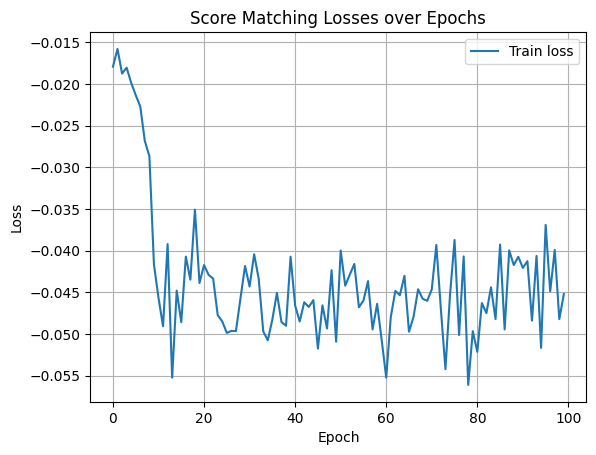

In [31]:
plt.plot(train_losses, label="Train loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Score Matching Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

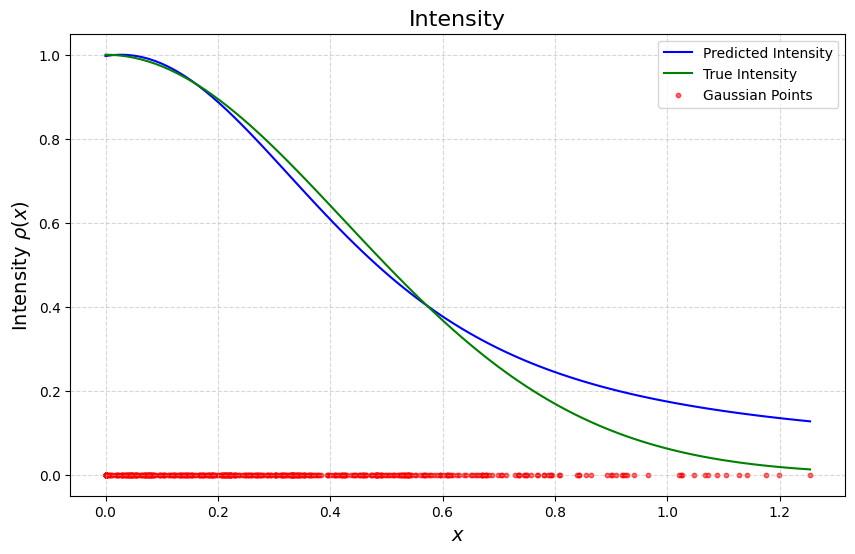

In [14]:
# Extract the 1D data
x = X_test[0][:, 0]

# Compute range for the 1D data
x_min, x_max = x.min(), x.max()

# Generate a 1D grid for intensity
x_lin = np.linspace(x_min, x_max, 100)  # Adjust resolution if needed

# Compute predicted intensity values for the grid
intensity_pred = model(torch.tensor(x_lin[:, None], dtype=torch.float32)).squeeze().detach().numpy()

# Compute true intensity values for the grid (assuming Gaussian distribution)
intensity_real = kappa * torch.exp(-x_lin[:, None]**2 / scale**2)

# Plot 1: Predicted Intensity Function
plt.figure(figsize=(10, 6))
plt.plot(x_lin, intensity_pred / np.max(intensity_pred), label='Predicted Intensity', color='blue')
# plt.plot(x_lin, intensity_pred, label='Predicted Intensity', color='blue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'Intensity $\rho(x)$', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Plot 2: True Intensity Function
plt.plot(x_lin, intensity_real / intensity_real.max(), label='True Intensity', color='green')
# plt.plot(x_lin, intensity_real, label='True Intensity', color='green')
plt.scatter(x, np.zeros_like(x), c='red', s=10, alpha=0.6, label='Gaussian Points')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'Intensity $\rho(x)$', fontsize=14)
plt.title('Intensity', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


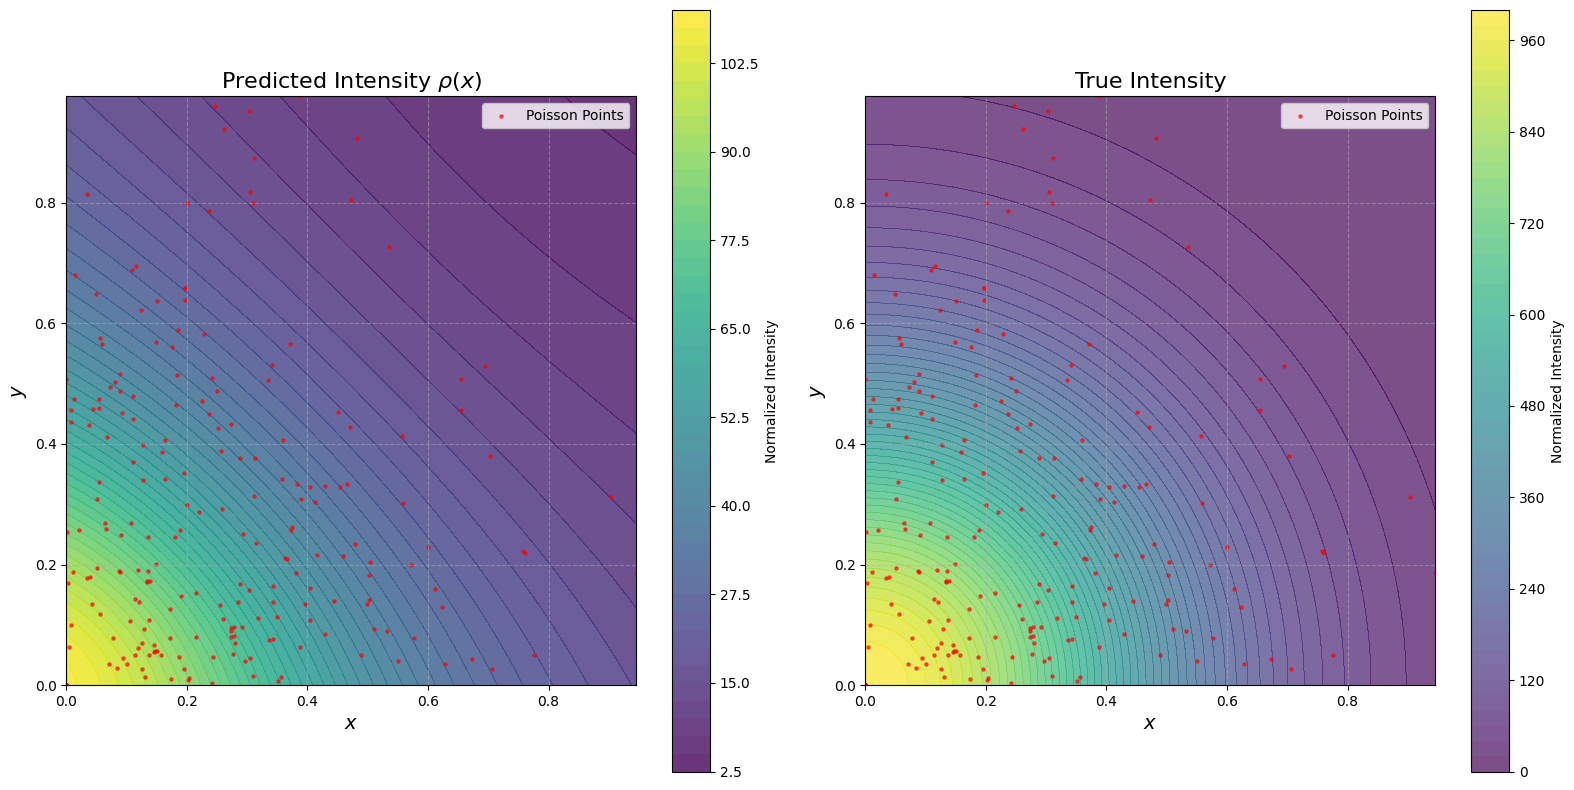

In [32]:
x = X_test[0][:, 0].numpy()
y = X_test[0][:, 1].numpy()
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

x_lin = np.linspace(x_min, x_max, 100)
y_lin = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_lin, y_lin)

grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
intensity_pred = model(torch.tensor(grid_points, dtype=torch.float32)).detach().numpy()
intensity_pred_2d = intensity_pred.reshape(xx.shape)
    
intensity_real = kappa.item() * np.exp(-(xx**2 + yy**2) / scale**2)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Model-predicted intensity
c1 = axs[0].contourf(
    xx, yy, intensity_pred_2d, levels=50,
    cmap='viridis', alpha=0.8, # vmin=0, vmax=1
)
axs[0].scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
axs[0].set_title(r'Predicted Intensity $\rho(x)$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=14)
axs[0].set_ylabel(r'$y$', fontsize=14)
axs[0].legend()
axs[0].set_aspect('equal')
axs[0].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(c1, ax=axs[0], label="Normalized Intensity")

# Plot 2: True intensity
if isinstance(intensity_real, torch.Tensor):
    intensity_real = intensity_real.numpy()
c2 = axs[1].contourf(
    xx, yy, intensity_real, levels=50,
    cmap='viridis', alpha=0.7, # vmin=0, vmax=1
)
axs[1].scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
axs[1].set_title('True Intensity', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=14)
axs[1].set_ylabel(r'$y$', fontsize=14)
axs[1].legend()
axs[1].set_aspect('equal')
axs[1].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(c2, ax=axs[1], label="Normalized Intensity")

plt.tight_layout()

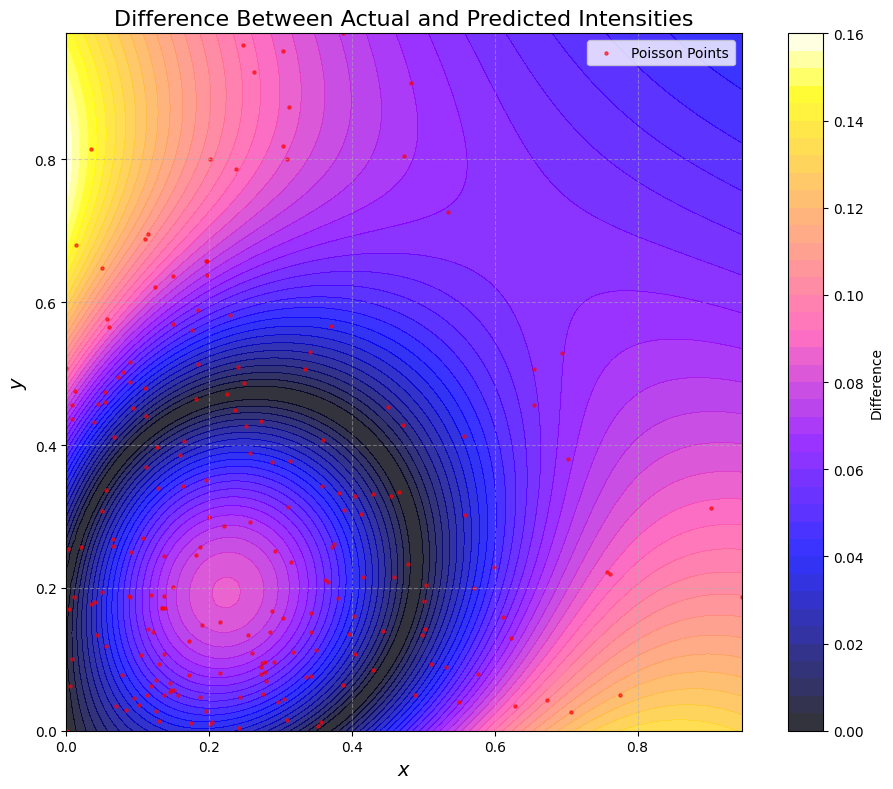

In [33]:
difference = abs((intensity_pred_2d / np.max(intensity_pred_2d)) - (intensity_real / np.max(intensity_real)))

plt.figure(figsize=(10, 8))
contour = plt.contourf(
    xx, yy, difference, levels=50, cmap='gnuplot2', alpha=0.8, #vmin=-1, vmax=1
)
plt.title("Difference Between Actual and Predicted Intensities", fontsize=16)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.scatter(x, y, c='red', s=5, alpha=0.6, label='Poisson Points')
plt.legend()
plt.gca().set_aspect('equal')
plt.colorbar(contour, label="Difference")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

In [15]:
def calculate_score_matching_difference(intensity_real, intensity_pred):
    """
    Calculate the Score Matching Difference (SMD) between the real and predicted intensities.

    Parameters:
    - intensity_real: Flattened array of real intensity values.
    - intensity_pred: Flattened array of predicted intensity values.

    Returns:
    - float: Score Matching Difference.
    """
    # Ensure inputs are numpy arrays
    intensity_real = np.asarray(intensity_real)
    intensity_pred = np.asarray(intensity_pred)
    
    # Compute the gradient of the log intensities
    gradient_real = np.gradient(np.log(intensity_real))
    gradient_pred = np.gradient(np.log(intensity_pred))
   
    return np.sum((gradient_real - gradient_pred) ** 2)

In [34]:
smd = calculate_score_matching_difference(intensity_real.ravel(), intensity_pred.ravel())
smd

np.float32(171.57509)

In [ ]:
mse_list = []
r2_list = []

# Iterate over the test loader
for batch in loader_test:
    for x_test in batch[0]:
        x_test = x_test[:, 0]

        intensity_real = kappa * torch.exp(-x_test[:, None]**2 / scale**2)
        intensity_real = np.asarray(intensity_real)

        # Predict intensities using the model
        intensity_pred = model(x_test[:, None]).squeeze().detach().numpy()

        # Normalize predicted and true intensities for consistency
        intensity_pred /= np.max(intensity_pred)
        intensity_real /= np.max(intensity_real)

        # Compute MSE and R-squared for this batch
        mse = mean_squared_error(intensity_real, intensity_pred)
        r2 = r2_score(intensity_real, intensity_pred)

        # Append metrics to the list
        mse_list.append(mse)
        r2_list.append(r2)

# Compute average MSE and R-squared over all test samples
average_mse = np.mean(mse_list)
average_r2 = np.mean(r2_list)

print(f"Average MSE across all test samples: {average_mse}")
print(f"Average R-squared across all test samples: {average_r2}")

Average MSE across all test samples: 0.0009896923264022916
Average R-squared across all test samples: 0.9872255861759186


In [35]:
mse_list = []
r2_list = []

# Iterate over the test loader
for batch in loader_test:
    for x_test in batch[0]:

        # Generate true intensity values (assuming Gaussian distribution as before)
        intensity_real = kappa.item() * np.exp(-(x_test[:, 0]**2 + x_test[:, 1]**2) / scale**2)
        intensity_real = np.asarray(intensity_real)

        # Predict intensities using the model
        intensity_pred = (
            model(torch.tensor(x_test[:, :-1], dtype=torch.float32)).squeeze().detach().numpy()
        )

        # Normalize predicted and true intensities for consistency
        intensity_pred /= np.max(intensity_pred)
        intensity_real /= np.max(intensity_real)

        # Compute MSE and R-squared for this batch
        mse = mean_squared_error(intensity_real, intensity_pred)
        r2 = r2_score(intensity_real, intensity_pred)

        # Append metrics to the list
        mse_list.append(mse)
        r2_list.append(r2)

# Compute average MSE and R-squared over all test samples
average_mse = np.mean(mse_list)
average_r2 = np.mean(r2_list)

print(f"Average MSE across all test samples: {average_mse}")
print(f"Average R-squared across all test samples: {average_r2}")

Average MSE across all test samples: 0.0026750627323053775
Average R-squared across all test samples: 0.9725847512483596


In [ ]:
num_experiments = 10
mse_results = []
r2_results = []
smd_results = []

num_samples = 100
train_ratio = 0.8
batch_size = 32

kappa = torch.tensor(1000.0)
scale = torch.tensor(0.6)

region = (0, 3)

epochs = 100
learning_rate = 1e-5

weighting = True

model_class = Poisson_NN

output_file = f"outputs/poisson_weighted_results_weighting_{weighting}_num_samples_{num_samples}_poly.txt"


with open(output_file, "w") as f:
    f.write(f"Poisson NN Score Matching Experiment Results\n")
    f.write(f"Number of Experiments: {num_experiments}\n")
    f.write(f"Number of Samples per Experiment: {num_samples}\n")
    f.write(f"Train Ratio: {train_ratio}\n")
    f.write(f"Batch Size: {batch_size}\n\n")
    f.write(f"Weighting: {weighting}\n\n")
    for exp in range(num_experiments):
        print(f"Running Experiment {exp + 1}/{num_experiments}...")

        # Generate new Poisson process samples
        samples = [torch.tensor(generate_poisson_points_1d(kappa, scale, region)).unsqueeze(-1) for _ in range(num_samples)]
        samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]

        # Prepare training and test data
        X = pad_sequence(samples_torch, batch_first=True, padding_value=0)
        lengths = torch.tensor([len(s) for s in samples_torch], dtype=torch.int64)
        lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
        X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

        m = len(X)
        train_size = int(train_ratio * m)

        X_train = X[:train_size]
        X_test = X[train_size:]

        loader_train = FastTensorDataLoader(X_train, batch_size=batch_size, shuffle=True)
        loader_test = FastTensorDataLoader(X_test, batch_size=batch_size, shuffle=False)

        # Train model
        model, train_losses = optimize_nn(
            loader_train, model_class, num_epochs=epochs, learning_rate=learning_rate, weighting=weighting
        )

        mse_list = []
        r2_list = []

        # Iterate over the test loader
        for batch in loader_test:
            for x_test in batch[0]:
                x_test = x_test[:, 0]

                intensity_real = kappa * torch.exp(-x_test[:, None]**2 / scale**2)
                intensity_real = np.asarray(intensity_real)

                # Predict intensities using the model
                intensity_pred = model(x_test[:, None]).squeeze().detach().numpy()

                # Normalize predicted and true intensities for consistency
                intensity_pred /= np.max(intensity_pred)
                intensity_real /= np.max(intensity_real)

                # Compute MSE and R²
                mse = mean_squared_error(intensity_real, intensity_pred)
                r2 = r2_score(intensity_real, intensity_pred)

                mse_list.append(mse)
                r2_list.append(r2)

        # Compute average MSE and R² for this experiment
        avg_mse = np.mean(mse_list)
        avg_r2 = np.mean(r2_list)

        # Compute SMD
        smd = calculate_score_matching_difference(intensity_real.ravel(), intensity_pred.ravel())

        # Store results
        mse_results.append(avg_mse)
        r2_results.append(avg_r2)
        smd_results.append(smd)

        print(f"Experiment {exp + 1} - MSE: {avg_mse:.6f}, R²: {avg_r2:.6f}, SMD: {smd:.6f}")

    # Compute final average metrics across all experiments
    final_mse = np.mean(mse_results)
    final_r2 = np.mean(r2_results)
    final_smd = np.mean(smd_results)
    
    f.write("\nFinal Results:\n")
    f.write(f"Mean MSE: {final_mse:.6f}\n")
    f.write(f"Mean R²: {final_r2:.6f}\n")
    f.write(f"Mean SMD: {final_smd:.6f}\n")

print("\nFinal Results:")
print(f"Mean MSE: {final_mse:.6f}")
print(f"Mean R²: {final_r2:.6f}")
print(f"Mean SMD: {final_smd:.6f}")

Running Experiment 1/10...


Training: 100%|██████████| 100/100 [00:19<00:00,  5.09epoch/s, Train Loss=-0.0722, Time/Epoch=0.19s]


Experiment 1 - MSE: 0.000477, R²: 0.993742, SMD: 11.483072
Running Experiment 2/10...


Training: 100%|██████████| 100/100 [00:19<00:00,  5.12epoch/s, Train Loss=-0.0709, Time/Epoch=0.18s]


Experiment 2 - MSE: 0.000423, R²: 0.994601, SMD: 12.912101
Running Experiment 3/10...


Training: 100%|██████████| 100/100 [00:21<00:00,  4.68epoch/s, Train Loss=-0.0732, Time/Epoch=0.22s]


Experiment 3 - MSE: 0.000312, R²: 0.996000, SMD: 9.393755
Running Experiment 4/10...


Training: 100%|██████████| 100/100 [00:20<00:00,  4.90epoch/s, Train Loss=-0.0779, Time/Epoch=0.19s]


Experiment 4 - MSE: 0.000501, R²: 0.993509, SMD: 21.002796
Running Experiment 5/10...


Training: 100%|██████████| 100/100 [00:21<00:00,  4.67epoch/s, Train Loss=-0.0730, Time/Epoch=0.18s]


Experiment 5 - MSE: 0.000479, R²: 0.993889, SMD: 11.019009
Running Experiment 6/10...


Training: 100%|██████████| 100/100 [00:20<00:00,  4.86epoch/s, Train Loss=-0.0713, Time/Epoch=0.22s]


Experiment 6 - MSE: 0.000764, R²: 0.990201, SMD: 25.076460
Running Experiment 7/10...


Training: 100%|██████████| 100/100 [00:20<00:00,  4.83epoch/s, Train Loss=-0.0677, Time/Epoch=0.28s]


Experiment 7 - MSE: 0.000409, R²: 0.994810, SMD: 9.452536
Running Experiment 8/10...


Training: 100%|██████████| 100/100 [00:22<00:00,  4.49epoch/s, Train Loss=-0.0758, Time/Epoch=0.22s]


Experiment 8 - MSE: 0.000321, R²: 0.995816, SMD: 5.333236
Running Experiment 9/10...


Training: 100%|██████████| 100/100 [00:22<00:00,  4.44epoch/s, Train Loss=-0.0789, Time/Epoch=0.23s]


Experiment 9 - MSE: 0.000955, R²: 0.987700, SMD: 32.001534
Running Experiment 10/10...


Training: 100%|██████████| 100/100 [00:20<00:00,  4.99epoch/s, Train Loss=-0.0719, Time/Epoch=0.18s]

Experiment 10 - MSE: 0.000809, R²: 0.989456, SMD: 7.719317

Final Results:
Mean MSE: 0.000545
Mean R²: 0.992972
Mean SMD: 14.539381
